In [2830]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # to make the kmean run smoothly

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import scipy.stats as ss
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
#from sklearn.preprocessing import RobustScaler
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap

In [2831]:
#import the data file 
df_data = pd.read_csv('wages_by_education.csv')
df_data.head()

,year,less_than_hs,high_school,some_college,bachelors_degree,advanced_degree,men_less_than_hs,men_high_school,men_some_college,men_bachelors_degree,...,black_women_less_than_hs,black_women_high_school,black_women_some_college,black_women_bachelors_degree,black_women_advanced_degree,hispanic_women_less_than_hs,hispanic_women_high_school,hispanic_women_some_college,hispanic_women_bachelors_degree,hispanic_women_advanced_degree
0,2022,16.52,21.94,24.81,41.60,53.22,17.99,24.08,27.96,49.01,...,13.89,17.83,20.36,29.94,39.41,14.74,18.18,20.64,31.13,40.64
1,2021,16.74,22.28,24.92,41.32,53.45,18.34,24.36,27.96,47.83,...,13.73,18.30,20.18,29.35,40.07,14.97,18.34,21.14,31.25,42.47
2,2020,17.02,22.70,25.44,41.65,53.74,18.76,25.09,28.55,48.15,...,13.66,17.93,20.31,31.38,42.44,14.58,18.50,20.69,31.55,44.15
3,2019,16.11,21.64,24.00,39.61,51.57,17.55,23.99,26.99,45.74,...,13.30,17.18,19.17,30.31,40.42,14.50,17.71,19.69,30.18,42.30
4,2018,15.94,21.50,23.70,38.87,51.03,17.70,23.72,26.61,44.97,...,12.48,16.81,18.57,30.85,39.64,13.47,17.28,19.29,29.47,39.35


In [2832]:
# information about the data
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             50 non-null     int64  
 1   less_than_hs                     50 non-null     float64
 2   high_school                      50 non-null     float64
 3   some_college                     50 non-null     float64
 4   bachelors_degree                 50 non-null     float64
 5   advanced_degree                  50 non-null     float64
 6   men_less_than_hs                 50 non-null     float64
 7   men_high_school                  50 non-null     float64
 8   men_some_college                 50 non-null     float64
 9   men_bachelors_degree             50 non-null     float64
 10  men_advanced_degree              50 non-null     float64
 11  women_less_than_hs               50 non-null     float64
 12  women_high_school       

In [2833]:
# perfrom Data cleaning,change the column to numerical
df_data = df_data.copy()
for col in df_data.columns[1:]:
    df_data[col] = pd.to_numeric(df_data[col]) 

# choose 6 interesting columns
df_data= df_data[['year','black_women_high_school',
                  'black_women_bachelors_degree','black_women_advanced_degree',
                  'hispanic_women_high_school','hispanic_women_bachelors_degree',
                  'hispanic_women_advanced_degree']]

In [2834]:
# dropping missing values, default is rows (axis=0) and how='any'
df_data.dropna(axis=1, how='all', inplace=True)

# rename column so help to make the data more 
df_data = df_data.rename(columns={'year':'Year',
                              'black_women_high_school':'Black Women High School',
                              'black_women_bachelors_degree':'Black Women Bachelor degree',
                              'black_women_advanced_degree':'Black Women Advanced degree',
                              'hispanic_women_high_school':'Hispanic Women High school',
                              'hispanic_women_bachelors_degree':'Hispanic Women Bachelor degree',
                              'hispanic_women_advanced_degree':'Hispanic Women Advanced degree' 
                                  })
df_data.head()

,Year,Black Women High School,Black Women Bachelor degree,Black Women Advanced degree,Hispanic Women High school,Hispanic Women Bachelor degree,Hispanic Women Advanced degree
0,2022,17.83,29.94,39.41,18.18,31.13,40.64
1,2021,18.30,29.35,40.07,18.34,31.25,42.47
2,2020,17.93,31.38,42.44,18.50,31.55,44.15
3,2019,17.18,30.31,40.42,17.71,30.18,42.30
4,2018,16.81,30.85,39.64,17.28,29.47,39.35


In [2835]:
# Summary of Data Statistics
df_data.describe()

,Year,Black Women High School,Black Women Bachelor degree,Black Women Advanced degree,Hispanic Women High school,Hispanic Women Bachelor degree,Hispanic Women Advanced degree
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000
mean,1997.50000,16.461400,27.924400,36.186200,16.597600,26.487400,34.75360
std,14.57738,0.700854,2.417531,3.123264,0.685984,3.219796,5.20913
min,1973.00000,15.530000,23.540000,29.340000,15.530000,18.850000,20.93000
25%,1985.25000,15.862500,25.985000,33.870000,16.115000,24.237500,30.95500
50%,1997.50000,16.300000,28.515000,37.160000,16.465000,27.390000,36.08500
75%,2009.75000,16.992500,30.110000,38.312500,16.982500,28.702500,38.37000
max,2022.00000,18.300000,31.380000,42.440000,18.500000,31.550000,44.15000


In [2836]:
# Visualisation of the correlation of the Dataset 
def plot_data_heatmap(data):
    """
    Correlation of the Dataset
    Plots the heatmap of the chosen data
    """
    fig, ax = plt.subplots(dpi=100)
    mask = np.triu(np.ones_like(data.corr(numeric_only=True)))
    sns.heatmap(data.corr(numeric_only=True), ax=ax, vmin=-1, vmax=1,
        cmap='RdBu', annot=True, mask=mask)
    plt.show()
    return

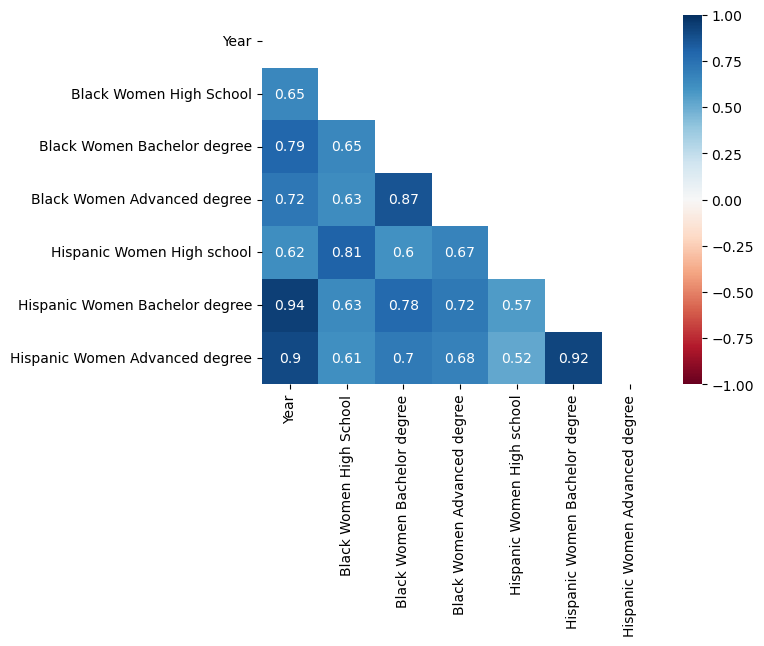

In [2837]:
# display the plot
plot_data_heatmap(df_data)

In [2838]:
# set the year column as the index
df_data = df_data.copy()
df_data.set_index('Year', inplace=True)

# focusing on the Data Hispanic women with bachelor degree due to its correlation
def plot_hist_data(columns):
    """
    Plots the histogram of Hispanic women with bachelor 
    """
    plt.figure(dpi=100)
    for i in columns:
        sns.histplot(df_data[i],label=i,bins=5, alpha=0.5,kde=True)
        plt.axvline(df_data[i].mean(), color='red', lw=1.5, ls='--', label= f'Mean: {df_data[i].mean():.2f}')
        plt.axvline(df_data[i].median(), color='blue', lw=1, ls='-', label= f'Median: {df_data[i].median():.2f}')
        plt.annotate(f'Skewness: {ss.skew(df_data[i]):.2f}', xy=(df_data[i].max()-12.1, 17), fontsize=8)
        plt.annotate(f'Kurtosis: {ss.kurtosis(df_data[i], fisher=False):.2f}',xy=(df_data[i].max()-12.1, 16), fontsize= 8)
        plt.annotate(f'Standard Deviation.: {np.std(df_data[i]):.2f}', xy=(df_data[i].max()-12.1, 15), fontsize= 8)
         
    #add titles and labels 
    plt.title('Wages Distribution of Hispanic Women with Bachelor Degree \n')
    plt.ylabel('Frequency',fontsize=10)
    plt.legend(loc='upper left',fontsize=6)
    plt.grid()
    plt.show()
    return


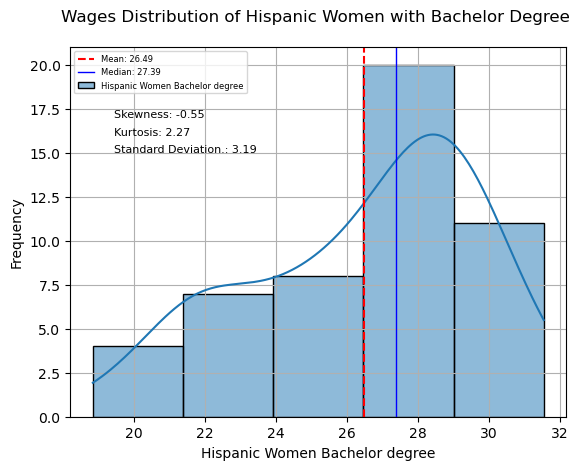

In [2839]:
# display the plot
plot_hist_data(['Hispanic Women Bachelor degree'])

In [2840]:
def plot_one_scatter_data(columns):
    """
    Plot the scatter graph of the Hispanic Women Bachelor degree againt year  
    """
    plt.figure(dpi=100)
    for i in columns:
        plt.scatter(df_data.index,df_data[i],label=i)
        
    #add titles and labels 
    plt.title('Scatter plot graph of Hispanic Women with Bachelor Degree \n')
    plt.xlabel('Year')
    plt.ylabel('Hourly Wages of Hispanic Women with Bachelor Degree ',fontsize=7)
    plt.legend(loc='upper left',fontsize=6)
    plt.grid()
    plt.show()
    return

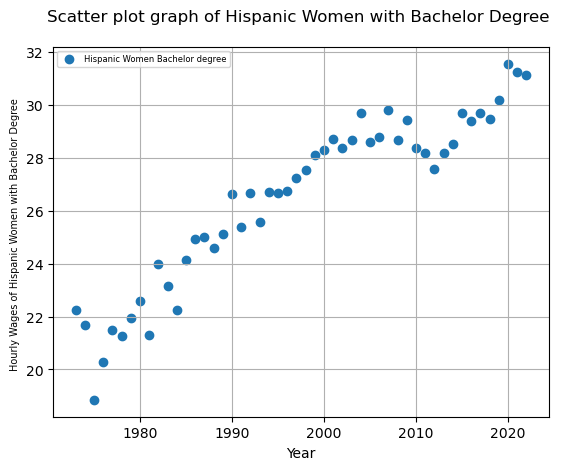

In [2841]:
plot_one_scatter_data(['Hispanic Women Bachelor degree'])

## Fitting

In [2843]:
def exponential(t, n0, g):
    """
    Calculates exponential function with scale factor n0 and growth rate g.
    """
    
    f = n0 * np.exp(g*t)
    
    return f

In [2844]:
# let's normalise the time frame of the data
numeric_index = (df_data.index - 1995).values

# give some initial guesses of N0 and growth
p, cov = curve_fit(exponential, numeric_index, df_data['Hispanic Women Bachelor degree'],
                   p0=(1.2e12, 0.03))

# get uncertainties on each parameter
sigma = np.sqrt(np.diag(cov))

#display the parameters
print(f"N0 = {p[0]:g} +/- {sigma[0]:g}")
print(f"g = {p[1]:.2f} +/- {sigma[1]:.2f}")

N0 = 25.8301 +/- 0.175828
g = 0.01 +/- 0.00


In [2845]:
def plot_exponential_fit(column):
    """
    plot the exponential graph of Hispanic Women Bachelor degree
    """
    fig, ax = plt.subplots(dpi=100)
    df_data['Exponential Fit'] = exponential(numeric_index, *p)
    df_data.plot(y=[column,'Exponential Fit'], logy=False, ax=ax, ylabel='Hispanic Women Bachelor degree')
    ax.set_title('Exponential graph of Hispanic Women with Bachelor degree \n')
    plt.show()
    return

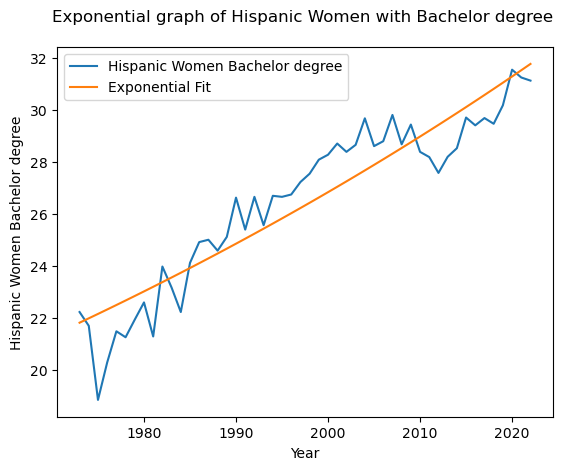

In [2846]:
# display the plot
plot_exponential_fit('Hispanic Women Bachelor degree')

In [2847]:
def logistic(t, n0, g, t0):
    """
    Calculates the logistic function with scale factor n0 and growth rate g
    """
    
    f = n0 / (1 + np.exp(-g*(t - t0)))
    
    return f

In [2848]:
p, cov = curve_fit(logistic, numeric_index, df_data['Hispanic Women Bachelor degree'],
                  p0=(1.2e12, 0.03, 10))

sigma = np.sqrt(np.diag(cov))

print(f"N0 = {p[0]:g} +/- {sigma[0]:g}")
print(f"g = {p[1]:.2f} +/- {sigma[1]:.2f}")
print(f"t0 = {p[2] + 1990:.2f} +/- {sigma[2]:.2f}")

N0 = 31.7814 +/- 0.827762
g = 0.05 +/- 0.01
t0 = 1957.79 +/- 1.40


In [2849]:
def plot_logistic_fit(column):
    """
    plot the logistic function of Hispanic Women with Bachelor degree.
    """
    fig, ax = plt.subplots(dpi=100)
    df_data['Logistic Fit'] = logistic(numeric_index, *p)
    df_data.plot(y=[column,'Logistic Fit'],ax=ax, ylabel='Hispanic Women Bachelor degree')
    ax.set_title('Logistic function graph of Hispanic Women with Bachelor degree \n')
    plt.show()
    return

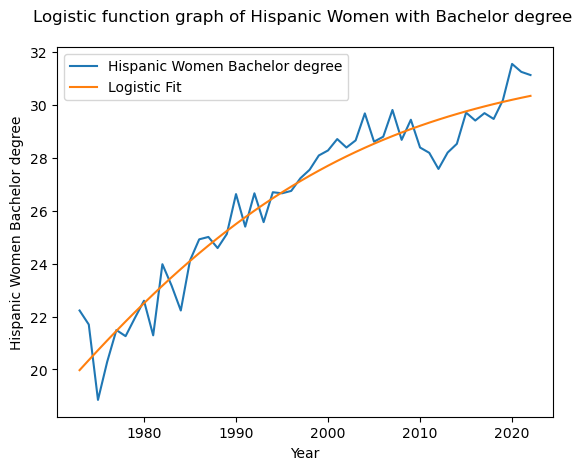

In [2850]:
# display the plot
plot_logistic_fit('Hispanic Women Bachelor degree')

In [2851]:
# Extrapolating of the Data into the next 8 years using logistic function
numeric_index = (df_data.index - 1995).values
p, cov = curve_fit(logistic, numeric_index, df_data['Hispanic Women Bachelor degree'],
                  p0=(1.2e12, 0.03, 10))
df_data_2030 = logistic(2030 - 1995, *p)  
print(f"Hispanic Women with Bachelor degree in 2030: {df_data_2030:g}") 

Hispanic Women with Bachelor degree in 2030: 30.8134


In [2852]:
# or take 2000 normal random samples for each parameter to find distribution of parameter of uncertainites
sample_params = ss.multivariate_normal.rvs(mean=p, cov=cov, size=2000)

# standard deviation of all possible parameter sampling
df_data_sd_2030 = np.std(logistic(2030 - 1995, *sample_params.T))  # note the transpose

print(f"Hispanic Women with Bachelor degree in 2030 : {df_data_2030:g} +/- {df_data_sd_2030:g}")

Hispanic Women with Bachelor degree in 2030 : 30.8134 +/- 0.412837


In [2853]:
def plot_time_prediction(data):
    """
    Calculate the distribution of the parameter uncertainty
    plot the time prediction graph 
    """
    fig, ax = plt.subplots(dpi=100)
    
    # create array of values within data, and beyond
    time_predictions = np.arange(1973, 2050, 5)
    
    # determine predictions for each of those times
    df_data_predictions = logistic(time_predictions - 1995, *p)
    
    # determine uncertainty at each prediction
    df_data_uncertainties = [np.std(logistic(future_time - 1995, *sample_params.T)) for future_time in time_predictions]

    #plot the graph of the extrapolation
    ax.plot(df_data.index, df_data['Hispanic Women Bachelor degree'], 'b-', label='Data')
    ax.plot(time_predictions, df_data_predictions, 'k-', label='Logistic Fit')
    ax.fill_between(time_predictions, df_data_predictions - df_data_uncertainties, df_data_predictions + df_data_uncertainties, 
                    color='gray', alpha=0.5,label='Confidence Interval')
    
    #add labels and titles
    ax.set_title('Extrapolating of the Data into the next 8 years using logistic function \n')
    ax.set_xlabel('Year')
    ax.set_ylabel('Wages of Hispanic Women with Bachelor degree')
    ax.legend()
    plt.show()
    return

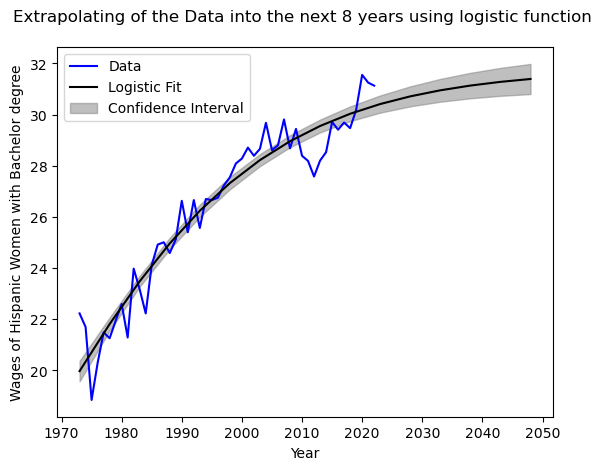

In [2854]:
plot_time_prediction(['Hispanic Women Bachelor degree'])


## Clustering


In [2856]:
# Alternative data column was utilized for clustering due to highly correlated data not suitable
df_cluster_data = df_data.reset_index()[['Year','Black Women Bachelor degree']].copy()
scaler = MinMaxScaler()
norm = scaler.fit_transform(df_cluster_data)
inv_norm = scaler.inverse_transform(norm)

In [2857]:
def plot_elbow_method(min_k, max_k, wcss, best_n):
    """
    Plots the elbow method between min_k and max_k
    """
    fig, ax = plt.subplots(dpi=100)
    ax.plot(range(min_k, max_k + 1), wcss, 'kx-')
    ax.scatter(best_n, wcss[best_n-min_k], marker='o', color='red', facecolors='none', s=50)
    ax.set_xlabel('k')
    ax.set_xlim(min_k, max_k)
    ax.set_ylabel('WCSS')
    plt.show()
    return

In [2858]:
def one_silhoutte_inertia(n, xy):
    """ 
    Calculates the silhoutte score and WCSS for n clusters 
    """
    # set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters=n, n_init=20)
    # Fit the data
    kmeans.fit(norm)
    labels = kmeans.labels_
    
    # calculate the silhoutte score
    score = silhouette_score(xy, labels)
    inertia = kmeans.inertia_

    return score, inertia

 2 clusters silhoutte score = 0.64
 3 clusters silhoutte score = 0.52
 4 clusters silhoutte score = 0.56
 5 clusters silhoutte score = 0.48
 6 clusters silhoutte score = 0.48
 7 clusters silhoutte score = 0.52
 8 clusters silhoutte score = 0.47
 9 clusters silhoutte score = 0.46
10 clusters silhoutte score = 0.46
Best number of clusters =  2


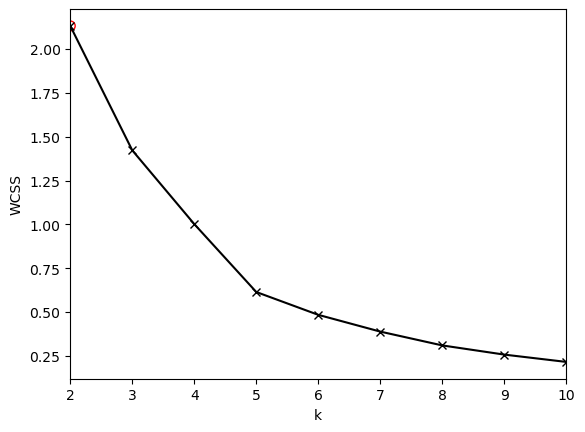

In [2859]:
# can automate the looking at cluster numbers (beware computational time)
wcss = []
best_n, best_score = None, -np.inf
for n in range(2, 11):  # 2 to 10 clusters
    score, inertia = one_silhoutte_inertia(n, norm)
    wcss.append(inertia)
    if score > best_score:
        best_n = n
        best_score = score
    print(f"{n:2g} clusters silhoutte score = {score:0.2f}")

print(f"Best number of clusters = {best_n:2g}")
plot_elbow_method(2, 10, wcss, best_n)

In [2860]:
def plot_clustered_area(labels, xy, xkmeans, ykmeans, centre_labels):
    """
    Plots clustered data as a scatter plot with determined centres shown
    """
    colours = plt.cm.Set1(np.linspace(0, 1, len(np.unique(labels))))
    cmap = ListedColormap(colours)
    
    fig, ax = plt.subplots(dpi=100)
    s = ax.scatter(xy[:, 0], xy[:, 1], c=labels, cmap=cmap, marker='o', label='Data')

    ax.scatter(xkmeans, ykmeans, c=centre_labels, cmap=cmap, marker='x', s=100, label='Estimated Centres')

    cbar = fig.colorbar(s, ax=ax)
    cbar.set_ticks(np.unique(labels))

    # add titles and labels
    ax.legend()
    ax.set_title('Clustered Data with determined Centres')
    ax.set_xlabel('Year')
    ax.set_ylabel('Wages')
    plt.show() 
    return

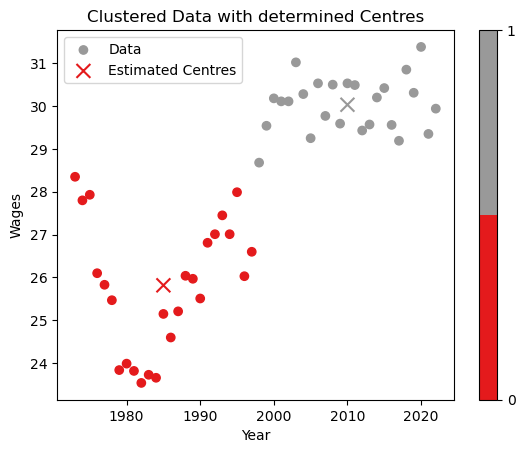

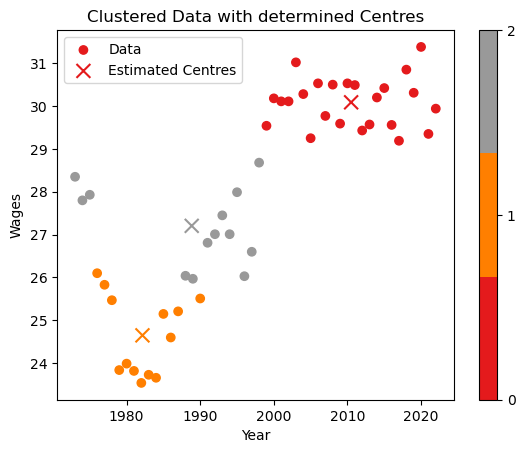

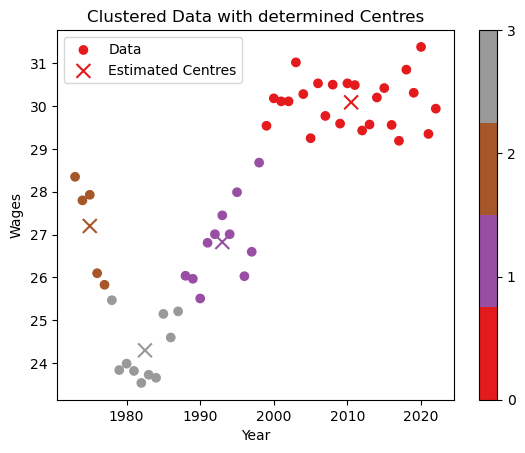

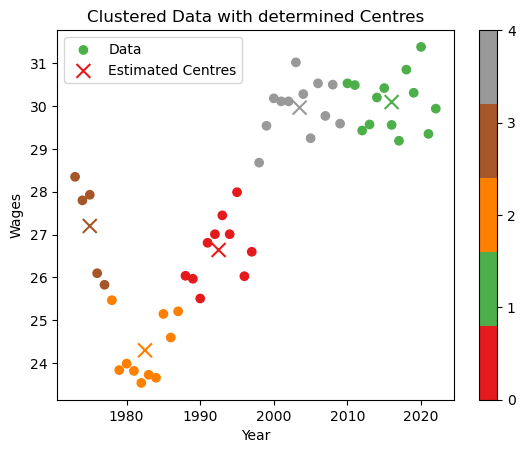

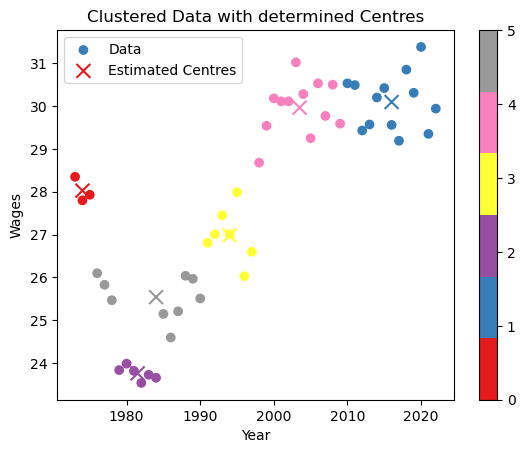

In [2861]:
# reverse back to the original dataset scale to plot accurately
inv_norm = scaler.inverse_transform(norm)  
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(norm)     
    labels = kmeans.labels_
    
    # the estimated cluster centres
    cen = scaler.inverse_transform(kmeans.cluster_centers_)
    xkmeans = cen[:, 0]
    ykmeans = cen[:, 1]
    cenlabels = kmeans.predict(kmeans.cluster_centers_)
    plot_clustered_area(labels, inv_norm, xkmeans, ykmeans, cenlabels)